In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import set_random_seed
set_random_seed(1)
plt.rcParams["figure.figsize"] = (12,7)
sns.set_style("darkgrid")

In [4]:
df = pd.read_csv("data/space_embedding_data.csv", index_col=[0])
df.head()

,Grid,PlaceCount,Price 1,Price 2,Price 3,Accommodation,Bar,Cafe,Cultural,Education,...,Health_rating,Other_rating,Outdoors_rating,Restaurant_rating,Retail_rating,Service_rating,Wholesale_rating,PositiveReviews,NegativeReviews,ReviewLength
0,L0,8,0,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.020000,0.0,3.942857,0.000000,0.000000,0.000000,0.696000,0.304000,0.536595
1,L1,10,0,1,0,0.0,0.0,1.0,0.0,0.0,...,5.0,0.000000,0.0,4.777778,0.000000,4.000000,0.000000,0.851852,0.148148,0.802238
2,L10,3,0,0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,4.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.857143,0.142857,0.999095
3,L100,74,2,9,6,12.0,6.0,6.0,0.0,1.0,...,3.6,4.024460,0.0,3.711172,4.500000,3.028846,0.000000,0.732975,0.267025,0.895548
4,L101,163,7,31,5,21.0,19.0,20.0,1.0,1.0,...,4.5,4.223132,0.0,3.748855,3.549446,4.311111,3.722222,0.801535,0.198465,0.843739


In [5]:
y = df[[i for i in df.columns if "_rating" not in i]].drop(["Grid"], axis=1)
X = pd.get_dummies(df.Grid).values

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
y_tf = sc.fit_transform(y)

# Space Embeddings model

## Continuous features

In [7]:
from keras.models import Model
from keras.layers import Dense, Embedding, Flatten
from keras import Input
# Parameters
input_neurons = X.shape[0]
output_neurons = y_tf.shape[1]

# Model architecture
inp = Input(shape=(input_neurons,))
emb = Embedding(input_dim=input_neurons, output_dim=8, input_length=input_neurons)(inp)
flat = Flatten()(emb)

dict_losses = {}
output_acts = []
for idx in range(len(y.columns)):
    output_act = Dense(1, activation="linear", use_bias=True, name="output_layer_cont" + str(idx))(flat)
    output_acts.append(output_act)
    dict_losses['output_layer_cont' + str(idx)] = 'mean_squared_error'

model = Model(inputs=inp, outputs=output_acts)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 480, 8)       3840        ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 3840)         0           ['embedding[0][0]']              
                                                                                                  
 output_layer_cont0 (Dense)     (None, 1)            3841        ['flatten[0][0]']                
                                                                                              

In [9]:
from keras.utils.vis_utils import plot_model
#plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

In [10]:
from tensorflow.keras.optimizers import Adam
import json

opt = Adam(learning_rate=0.01)
model.compile(loss=dict_losses, optimizer=opt)

batch_size = 64
epochs = 10
history = model.fit(X, y_tf, batch_size=batch_size, epochs=epochs, verbose=3)

# save weights
weights_countinous ={df.Grid[idx]: [str(i) for i in w] for idx, w in enumerate(model.layers[1].get_weights()[0])}
f = open("embedding_weights/weights_continous.json", "w")
json.dump(weights_countinous, f)
f.close()

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


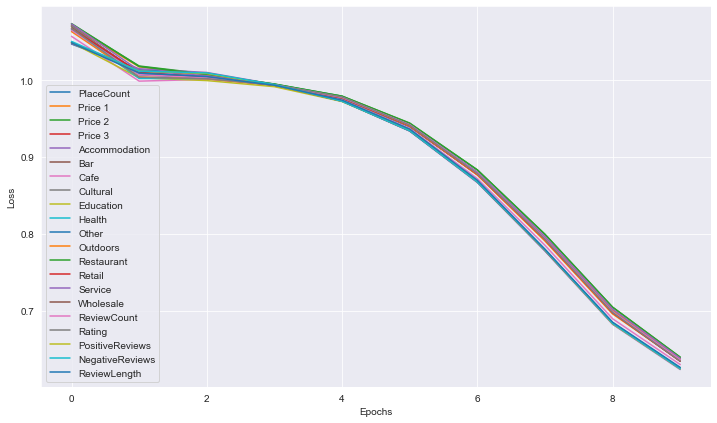

In [11]:
for idx, (key, value) in enumerate(history.history.items()):
    if key != "loss":
        plt.plot(history.epoch, value, label=y.columns[idx-1])
plt.ylabel("Loss")
plt.xlabel("Epochs");
plt.legend();

In [12]:
from sklearn.metrics import mean_squared_error
continuous_model = []
y_pred = model.predict(X)
y_pred = np.array(y_pred).T.squeeze()
for i in range(y_pred.shape[1]):
    mse_feature = mean_squared_error(y_tf[:, i], y_pred[:, i])
    print(y.columns[i], "MSE:", mse_feature)
    continuous_model.append(mse_feature)

PlaceCount MSE: 0.23519487151884705
Price 1 MSE: 0.4234854559397713
Price 2 MSE: 0.34757310768696087
Price 3 MSE: 0.4007832104948193
Accommodation MSE: 0.7559279150873316
Bar MSE: 0.43904312681768604
Cafe MSE: 0.3737998210722176
Cultural MSE: 0.4694783140344891
Education MSE: 0.6142279913726258
Health MSE: 0.5174906973078685
Other MSE: 0.3694449678521275
Outdoors MSE: 0.755632873357239
Restaurant MSE: 0.33009956126793555
Retail MSE: 0.36372425510183337
Service MSE: 0.3430551077923877
Wholesale MSE: 0.45962665117965357
ReviewCount MSE: 0.332981208695792
Rating MSE: 1.297631685838149
PositiveReviews MSE: 1.225628606172961
NegativeReviews MSE: 1.4596609515740662
ReviewLength MSE: 1.2022864501547472


In [23]:
#### Grid Search 
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor

def create_model(embedding_dim, lr):
    input_neurons = X.shape[0]

    # Model architecture
    inp = Input(shape=(input_neurons,))
    emb = Embedding(input_dim=input_neurons, output_dim=embedding_dim, input_length=input_neurons)(inp)
    flat = Flatten()(emb)

    dict_losses = {}
    output_acts = []
    for idx in range(len(y.columns)):
        output_act = Dense(1, activation="linear", use_bias=True, name="output_layer_cont" + str(idx))(flat)
        output_acts.append(output_act)
        dict_losses['output_layer_cont' + str(idx)] = 'mean_squared_error'

    model = Model(inputs=inp, outputs=output_acts)
    opt = Adam(learning_rate=lr)
    model.compile(loss=dict_losses, optimizer=opt)
    return model

model = KerasRegressor(build_fn=create_model, verbose=0, epochs=1, batch_size=64)
param_names = ["dim", "lr"]
parameters = [np.arange(5, 7, 1), np.arange(0.01, 0.5, 0.1)]
param_grid = {param_names[i]: parameters[i] for i in range(len(param_names))}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(X, y_tf)

ValueError: Invalid parameter dim for estimator KerasRegressor.
This issue can likely be resolved by setting this parameter in the KerasRegressor constructor:
`KerasRegressor(dim=5)`
Check the list of available parameters with `estimator.get_params().keys()`

In [25]:
model.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])

## Discrete/categorical features

In [11]:
from sklearn.manifold import TSNE
embeddings = model.layers[1].get_weights()[0]
colors = (df.Grid.str.startswith("L")*1).values
colors = ["red" if i==1 else "blue" for i in colors]
X_emb = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(embeddings)

plt.figure(figsize=(12,7))
plt.scatter(X_emb[:, 0], X_emb[:, 1], color=colors);

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')